# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [1]:
#Imports
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, hamming_loss, jaccard_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#built heavily off of https://www.tensorflow.org/text/tutorials/text_classification_rnn

Import `matplotlib` and create a helper function to plot graphs:

In [110]:
#other setup
tfds.disable_progress_bar()
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The steam reviews data used initially here is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

In [115]:
# Parse the data
dataset = pd.read_csv('games_reviews_genres_encoded.csv')
dataset['Indie'] = dataset['Indie'].astype(int)
dataset['Casual'] = dataset['Casual'].astype(int)
dataset['Adventure'] = dataset['Adventure'].astype(int)
dataset['reviews'] = dataset['reviews'].astype(str)
train_dataset = dataset.sample(frac=0.8, random_state=0) # 80% train test split
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset.shape)
print(train_dataset.columns)
train_dataset = train_dataset[['reviews', 'Indie', 'Casual', 'Adventure']]
test_dataset = test_dataset[['reviews', 'Indie', 'Casual', 'Adventure']]
train_dataset.head()

(6201, 31)
Index(['Unnamed: 0', 'AppID', 'reviews', 'Genres', 'Tags', 'Price',
       'Estimated.owners', 'Indie', 'Strategy', 'Action', 'Casual',
       'Simulation', 'Sports', 'Adventure', 'Early_Access', 'Utilities', 'RPG',
       'Massively_Multiplayer', 'Free_To_Play', 'Racing', 'Violent', 'Gore',
       'Animation_and_Modeling', 'Design_and_Illustration', 'Video_Production',
       'Nudity', 'Sexual_Content', 'Software_Training', 'Education',
       'Game_Development', 'Audio_Production'],
      dtype='object')


,reviews,Indie,Casual,Adventure
2036,This game is broken.\r\n\r\nIt isn't possible ...,1,0,1
572,HORRIBLE GAME definetly not worth buying there...,1,0,0
2570,Surprisingly I enjoy it despite the mixed gene...,0,0,1
5776,I thought i'd give it a go because its hard to...,1,0,0
4737,I will admit that I enjoyed The Fox’s Trail a ...,0,0,1


In [117]:
#check distribution of the categories among training and test datasets
print(np.sum(train_dataset[['Indie', 'Casual', 'Adventure']], axis=0))
print(np.sum(test_dataset[['Indie', 'Casual', 'Adventure']], axis=0))

Indie        4439
Casual       2548
Adventure    2411
dtype: int64
Indie        1113
Casual        629
Adventure     576
dtype: int64


In [118]:
#convert to tfds
tf_train_dataset = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
tf_test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_dataset))
tf_train_dataset.element_spec

{'reviews': TensorSpec(shape=(), dtype=tf.string, name=None),
 'Indie': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'Casual': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'Adventure': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [120]:
#print element from data, one game's reviews and its associated class labels
for elem in tf_train_dataset.take(1):
  print('Reviews: ', elem['reviews'].numpy())
  print('Indie: ', elem['Indie'].numpy())
  print('Casual: ', elem['Casual'].numpy())
  print('Adventure: ', elem['Adventure'].numpy())

Reviews:  b'This game is broken.\r\n\r\nIt isn\'t possible to open chests or use your "special ability," and the level doesn\'t have an exit or an end boss.'
Indie:  1
Casual:  0
Adventure:  1


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [121]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [122]:
tf_train_dataset = tf_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_test_dataset = tf_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [124]:
#print sample (1 batch) from data, three games reviews and their associated class labels
for element in tf_train_dataset.take(1):
  print('reviews: ', element['reviews'].numpy()[:3])
  print()
  print('Indie: ', element['Indie'].numpy()[:3])
  print('Casual:', element['Casual'].numpy()[:3])
  print('Adventure: ', element['Adventure'].numpy()[:3])

reviews:  [b'Really enjoyed the time that I had with my pals during this game. So much nice and friendly and DEEP conversation that we had during the time of play. I would recommend this game to anyone who is socially inept because it can teach you how to talk to someone one on one during the awkward times.|;|well for the price a $1 nothing could go wrong. this game is exactly what it says it is, fire and chat. nothing more, nothing less 10/10 had a okay time'
 b'It\'s just 2048, without score and a bit faster.\r\n\r\nIt\'s fun, sure, but there is really no point in getting this game, as the full version is already free online. Maybe if this game were expanded to have more modes and features it would be worth it.|;|Really like the 1048 games, its a good way to mentally check out at the end of the day. The in game music is a nice mix of calming with out feeling "tired".|;|Played so far for only 20 mintues. Im relaxed.  I play some more and more and more.  Ty Killgame A+\r\n\r\nhttps://w

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

There is room for improvement here, vectorization with certain dictionaries or parameters may affect model accuracy.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [182]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 10000 # Define a maximum sequence length
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH) # Add output_sequence_length
encoder.adapt(tf_train_dataset.map(lambda x: x['reviews']))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

Note: Should filter for significant tokens. 'a' and 'the' and 'in' and so on are not helpful.

In [183]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'to', 'a', 'game', 'of', 'i', 'is',
       'it', 'you', 'this', 'in', 'that', 'for', 'but', 'with', 'are',
       'on'], dtype='<U31')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [184]:
encoded_example = encoder(element['reviews'])[:3].numpy()
encoded_example

array([[  44,  294,    2, ...,    0,    0,    0],
       [  20,   28,    1, ...,    0,    0,    0],
       [ 463,    2, 1628, ...,    0,    0,    0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [185]:
for n in range(3):
  print("Original: ", element['reviews'][n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Really enjoyed the time that I had with my pals during this game. So much nice and friendly and DEEP conversation that we had during the time of play. I would recommend this game to anyone who is socially inept because it can teach you how to talk to someone one on one during the awkward times.|;|well for the price a $1 nothing could go wrong. this game is exactly what it says it is, fire and chat. nothing more, nothing less 10/10 had a okay time'
Round-trip:  really enjoyed the time that i had with my [UNK] during this game so much nice and friendly and deep conversation that we had during the time of play i would recommend this game to anyone who is [UNK] [UNK] because it can teach you how to talk to someone one on one during the awkward [UNK] for the price a 1 nothing could go wrong this game is exactly what it says it is fire and chat nothing more nothing less 1010 had a okay time                                                                                          

## Create the model

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

4. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [186]:
single_prediction_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5), #forestall overfitting
    tf.keras.layers.Dense(1)
])

# Summary of the model
single_prediction_model.summary()

#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Compile the model
single_prediction_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['binary_accuracy']
)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_39                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_40                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [187]:
print([layer.supports_masking for layer in single_prediction_model.layers])

[False, True, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [188]:
# predict on a sample text without padding.

sample_text = "The game was cool. The animation and the graphics were out of this world. I would recommend this game."
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)

# Exapanded layers to see output
layer2 = tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
layer2_output = layer2(encoded_example)

layer3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
layer3_output = layer3(layer2_output)

layer4 = tf.keras.layers.Dense(64, activation='relu')
layer4_output = layer4(layer3_output)

layer5 = tf.keras.layers.Dense(1)
layer5_output = layer5(layer4_output)

predictions = single_prediction_model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-0.00062557]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [179]:
# predict on a sample text with padding

padding = "the " * 2000
encoded_padding = tf.expand_dims(encoder(padding), axis=0)

predictions = single_prediction_model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
[-0.00955341]


## Train the model

We train models on each category indiviudally, to demonstrate the feasiblity of predicting genre correctly for each category.

In [180]:
encoded_Indie_train = tf_train_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie']], axis=-1)))
encoded_Indie_test = tf_test_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie']], axis=-1)))

single_prediction_model.fit(encoded_Indie_train, epochs=10,
                    validation_data=encoded_Indie_test,
                    validation_steps=30)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - binary_accuracy: 0.5083 - loss: 0.6366 - val_binary_accuracy: 0.7181 - val_loss: 0.5938
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - binary_accuracy: 0.6621 - loss: 0.6063 - val_binary_accuracy: 0.5606 - val_loss: 0.6003
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - binary_accuracy: 0.7435 - loss: 0.5190 - val_binary_accuracy: 0.6671 - val_loss: 0.5981
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - binary_accuracy: 0.8346 - loss: 0.3766 - val_binary_accuracy: 0.6277 - val_loss: 0.6688
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - binary_accuracy: 0.8977 - loss: 0.2586 - val_binary_accuracy: 0.6587 - val_loss: 0.9672
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - binary_accuracy: 0.9391 - loss: 0.1689 - val_binary_accuracy: 0.6174 - val_loss: 1.1615
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - binary_accuracy: 0.9569 - loss: 0.1250 - val_binary_accuracy: 0.6000 - val_loss: 1.3561
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - binary_accuracy: 0.9712 - loss: 0.0878 - val_binary_accuracy: 0.6503 - val_loss: 1.2950
Epoch 9/10

In [181]:
single_prediction_model.save_weights('./Indie-model.weights.h5')

In [133]:
encoded_Casual_train = tf_train_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Casual']], axis=-1)))
encoded_Casual_test = tf_test_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Casual']], axis=-1)))

single_prediction_model.fit(encoded_Casual_train, epochs=10,
                    validation_data=encoded_Casual_test,
                    validation_steps=30)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 824ms/step - accuracy: 0.5853 - loss: 0.6831 - val_accuracy: 0.5942 - val_loss: 0.6695
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


97/97 ━━━━━━━━━━━━━━━━━━━━ 78s 808ms/step - accuracy: 0.6018 - loss: 0.6417 - val_accuracy: 0.6245 - val_loss: 0.6386
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 76s 785ms/step - accuracy: 0.7317 - loss: 0.5188 - val_accuracy: 0.6574 - val_loss: 0.6598
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 78s 811ms/step - accuracy: 0.8092 - loss: 0.3996 - val_accuracy: 0.6665 - val_loss: 0.7204
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 79s 815ms/step - accuracy: 0.8885 - loss: 0.2756 - val_accuracy: 0.6123 - val_loss: 0.9730
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 76s 791ms/step - accuracy: 0.9171 - loss: 0.2025 - val_accuracy: 0.6329 - val_loss: 0.9998
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 76s 776ms/step - accuracy: 0.9457 - loss: 0.1376 - val_accuracy: 0.6310 - val_loss: 1.1186
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 79s 822ms/step - accuracy: 0.9592 - loss: 0.1032 - val_accuracy: 0.6484 - val_loss: 1.4606
Epoch 9/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 79s 798ms/step - accuracy: 0.9668 - loss: 0.0823 - val_accuracy: 0.632

In [134]:
single_prediction_model.save_weights('./Casual-model.weights.h5')

In [189]:
encoded_Adventure_train = tf_train_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Adventure']], axis=-1)))
encoded_Adventure_test = tf_test_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Adventure']], axis=-1)))

single_prediction_model.fit(encoded_Adventure_train, epochs=10,
                    validation_data=encoded_Adventure_test,
                    validation_steps=30)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - binary_accuracy: 0.6133 - loss: 0.6755 - val_binary_accuracy: 0.6284 - val_loss: 0.6540
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - binary_accuracy: 0.6144 - loss: 0.6500 - val_binary_accuracy: 0.6510 - val_loss: 0.6440
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - binary_accuracy: 0.7246 - loss: 0.5211 - val_binary_accuracy: 0.6574 - val_loss: 0.6739
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - binary_accuracy: 0.8335 - loss: 0.3921 - val_binary_accuracy: 0.6471 - val_loss: 0.7994
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - binary_accuracy: 0.8822 - loss: 0.2790 - val_binary_accuracy: 0.6368 - val_loss: 1.0028
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - binary_accuracy: 0.9169 - loss: 0.1967 - val_binary_accuracy: 0.6361 - val_loss: 1.2774
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - binary_accuracy: 0.9498 - loss: 0.1388 - val_binary_accuracy: 0.6168 - val_loss: 1.4524

In [190]:
single_prediction_model.save_weights('./Adventure-model.weights.h5')

As can be seen, the models predict the classes with high accuracy on both the training and validation datasets.

Now we try to build a model for predicting all the categories at once. This is a multi-layer classification problem, introducing additional complexity because the genre classes are not mutually exclusive.

We reconstruct the model to use sigmoid activation in the final layer, and an output value for each class. We also introduce an additional LSTIM layer to deal with the increased complexity.

Because we are now dealing with multiple classes who are unequally represented in the dataset, we must also calculate class distribution to inform our loss function.

In [191]:
multilabel_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5), #forestall overfitting
    tf.keras.layers.Dense(3, activation='sigmoid') #changed from softmax
])

# Summary of the model
multilabel_model.summary()

#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Compile the model
multilabel_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_36 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_42                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_43                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [192]:
encoded_train_dataset = tf_train_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie'], x['Casual'], x['Adventure']], axis=-1)))
encoded_test_dataset = tf_test_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie'], x['Casual'], x['Adventure']], axis=-1)))

# Calculate genre distribution
class_counts = np.sum(train_dataset[['Indie', 'Casual', 'Adventure']], axis=0)
print(class_counts)
total_samples = len(train_dataset[['Indie', 'Casual', 'Adventure']])
print(total_samples) #because the classes are not exclusive, this is not the two class counts added together
class_weights = total_samples / (class_counts * len(class_counts))
class_weights = class_weights.tolist()
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

Indie        4439
Casual       2548
Adventure    2411
dtype: int64
6201


In [193]:
history = multilabel_model.fit(encoded_train_dataset, epochs=10,
                    validation_data=encoded_test_dataset,
                    validation_steps=30,
                    class_weight=class_weights_dict)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.7759 - loss: 0.3571 - val_accuracy: 0.8671 - val_loss: 0.6534
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.8376 - loss: 0.3532 - val_accuracy: 0.8671 - val_loss: 0.6479
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.7873 - loss: 0.3368 - val_accuracy: 0.8206 - val_loss: 0.6328
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.6869 - loss: 0.3076 - val_accuracy: 0.5935 - val_loss: 0.6452
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - accuracy: 0.6554 - loss: 0.2720 - val_accuracy: 0.5600 - val_loss: 0.6949
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.6550 - loss: 0.2438 - val_accuracy: 0.5710 - val_loss: 0.7555
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 250ms/step - accuracy: 0.6673 - loss: 0.2166 - val_accuracy: 0.6310 - val_loss: 0.7804
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.6646 - loss: 0.1942 - val_accuracy: 0.5110 - val_loss: 0.9095
Epoch 9/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.6514 - loss: 0.1745 - val_accuracy: 0.496

In [194]:
#https://www.tensorflow.org/tutorials/keras/save_and_load
multilabel_model.save_weights('./multilabel-model.weights.h5')

In [195]:
multilabel_model.evaluate(encoded_test_dataset)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.4877 - loss: 1.1233


[1.1428574323654175, 0.49677419662475586]

In [196]:
#Gemini generated chunk

# Retrieve the original unbatched test reviews and labels directly from the `test_dataset` DataFrame
# This ensures perfect alignment between reviews and their true labels.
test_reviews_original = test_dataset['reviews'].values
y_true = test_dataset[['Indie', 'Casual', 'Adventure']].values # Ensure correct order and type

# Encode the reviews for prediction using the pre-trained encoder
encoded_test_reviews_for_prediction = encoder(test_reviews_original)

# Create a tf.data.Dataset from the encoded reviews for batching during prediction
prediction_dataset = tf.data.Dataset.from_tensor_slices(encoded_test_reviews_for_prediction).batch(BATCH_SIZE)

# Get predictions from the model
y_pred_probs = multilabel_model.predict(prediction_dataset)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

misclassified_reviews_list = []
misclassified_true_labels_list = []
misclassified_predicted_labels_list = []
misclassified_predicted_probabilities_list=[]

# Iterate through each sample to find misclassified ones
# A sample is misclassified if its predicted binary labels do not exactly match the true binary labels
for i in range(len(y_true)): # Loop up to the length of true labels
    if not np.array_equal(y_pred_binary[i], y_true[i]):
        misclassified_reviews_list.append(test_reviews_original[i])
        misclassified_true_labels_list.append(y_true[i])
        misclassified_predicted_probabilities_list.append(y_pred_probs[i])
        misclassified_predicted_labels_list.append(y_pred_binary[i])


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step


In [197]:
print(f"\nNumber of misclassified samples: {len(misclassified_reviews_list)}")
print(f"\nTotal number of samples: {len(y_true)}")
print("\nFirst 100 Misclassified Predictions:\n")
for i in range(min(100, len(misclassified_reviews_list))):
    print(f"True Labels (Indie, Casual, Adventure): {misclassified_true_labels_list[i]}")
    print(f"Predicted Probabilities (Indie, Casual, Adventure): {misclassified_predicted_probabilities_list[i]}")
    print(f"Predicted Labels (Indie, Casual, Adventure): {misclassified_predicted_labels_list[i]}")


Number of misclassified samples: 1199

Total number of samples: 1550

First 100 Misclassified Predictions:

True Labels (Indie, Casual, Adventure): [1 0 0]
Predicted Probabilities (Indie, Casual, Adventure): [0.01107434 0.00459617 0.7483788 ]
Predicted Labels (Indie, Casual, Adventure): [0 0 1]
True Labels (Indie, Casual, Adventure): [1 0 1]
Predicted Probabilities (Indie, Casual, Adventure): [0.42588192 0.1744873  0.4807601 ]
Predicted Labels (Indie, Casual, Adventure): [0 0 0]
True Labels (Indie, Casual, Adventure): [1 1 0]
Predicted Probabilities (Indie, Casual, Adventure): [0.25376993 0.7144124  0.42922327]
Predicted Labels (Indie, Casual, Adventure): [0 1 0]
True Labels (Indie, Casual, Adventure): [1 0 1]
Predicted Probabilities (Indie, Casual, Adventure): [0.10922736 0.1083754  0.49451283]
Predicted Labels (Indie, Casual, Adventure): [0 0 0]
True Labels (Indie, Casual, Adventure): [1 0 1]
Predicted Probabilities (Indie, Casual, Adventure): [0.06261107 0.03776205 0.58156383]
Pred

(0.0, 1.1917599759995938)

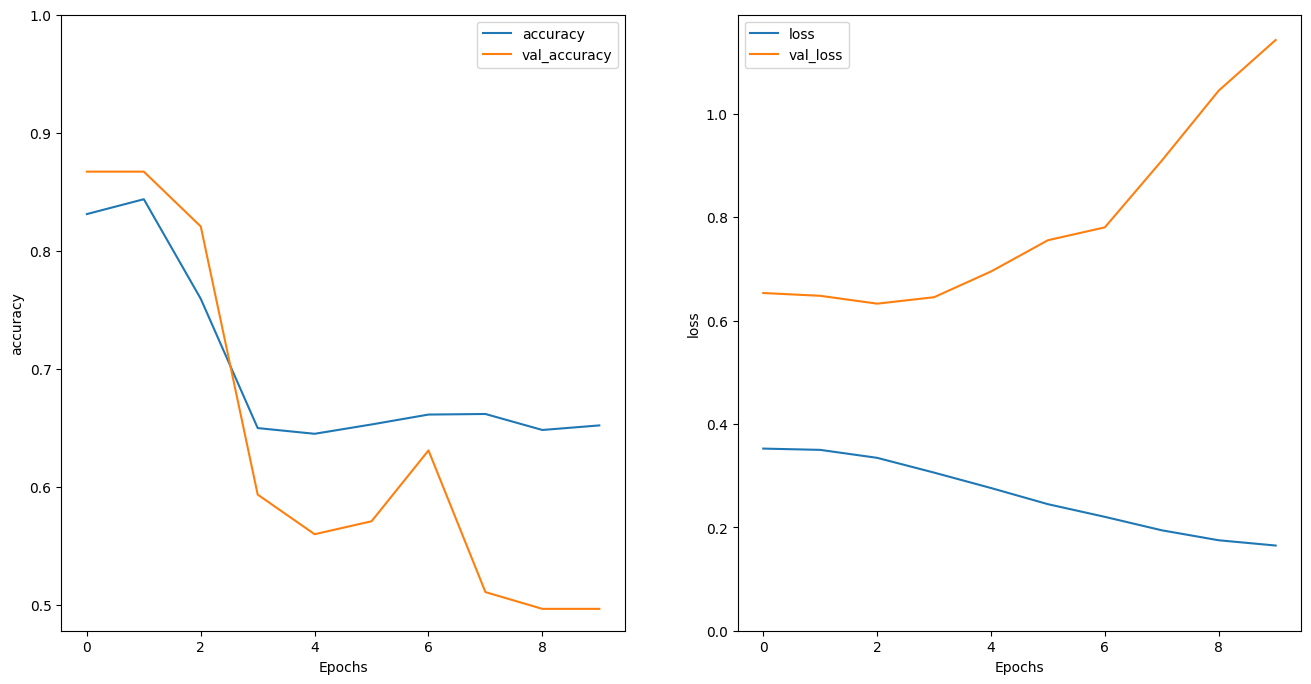

In [198]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [201]:
sample_text = ('This was an indie game. It was not an adventure game. It was not a casual game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = multilabel_model.predict(encoded_example)
print(predictions)

sample_text = ('This game was cool. I like the way it doesnt take too much energy. '
                'Shoutout to the small team of devs that made it possible. I would recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = multilabel_model.predict(encoded_example)
print(predictions)

sample_text = ('This game was not cool. The animation and the graphics '
               'looked expensive but the gameplay was soulless. Disgrace of a AAA game.'
               'I would not recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = multilabel_model.predict(encoded_example)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
[[0.8172657  0.95058745 0.3638076 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
[[0.91552234 0.02512031 0.5136164 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
[[0.14134116 0.99888617 0.3095823 ]]





Another way of going about this same process, noted here in case we have to resort to it.

In [ ]:
# Train the https://keras.io/examples/nlp/multi_label_classification/  model
# Binary Relevance with Logistic Regression
binary_relevance = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, random_state=42)
)
binary_relevance.fit(x_train, y_train)

In [ ]:
# Make predictions
y_pred_br = binary_relevance.predict(x_test)
y_pred_proba_br = binary_relevance.predict_proba(x_test)

# Evaluate performance
hamming_loss_br = hamming_loss(y_test, y_pred_br)
jaccard_score_br = jaccard_score(y_test, y_pred_br, average='samples')

print(f"Binary Relevance Results:")
print(f"Hamming Loss: {hamming_loss_br:.4f}")
print(f"Jaccard Score: {jaccard_score_br:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c